### Toy problem simulating non-stationary timeseries with "regime-shift"

Compare prediction performance of base Echo State Networks (ESNs) with CNN/LSTM hybrid network.

**Outline**

Create timeseries with increasing complexity / difficulty:

1. sin + noise, one amplitude $a_1$, one frequency $f_1$
2. **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_1$, one frequency $f_2$
3. **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_2$, one frequency $f_1$
4. **1st half**: sin + noise, one amplitude $a_1$, one frequency $f_1$, **2nd half**: sin + noise, one amplitude $a_2$, one frequency $f_2$

Look at accuracy (correctly predicted up/down movements) and mean-absolute-error (mae) in total and seperately for both regimes.

**Possible extensions**

* Neglect trend in first step, assume de-trending series is not a big deal.
* Could try to increase noise or different noise-regimes.



### Technical setup and data preparation

In [1]:
import time
import math
import numpy as np
from scipy.special import expit  # vectorized logistig function
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr

# Work with my own library of useful ESN functions
from ESN_functions_v01 import *

In [2]:
### Create some data

# Specify number of steps per regime.
n_ = 1000

# Specify input for sin function with linspace(start, stop, numsteps)
t = np.linspace(0, 20*np.pi, n_) 

In [20]:
# Create input_1: 

# Set the one amplitude a1, and one base frequency f1
a1 = 1
f1 = 1

# Set noise standard deviation parameter n1
n1 = 1

# Add noise with np.random.normal(mean, std, numsteps).
input_1 = a1 * np.sin(f1 * t) + np.random.normal(0, n1, n_)

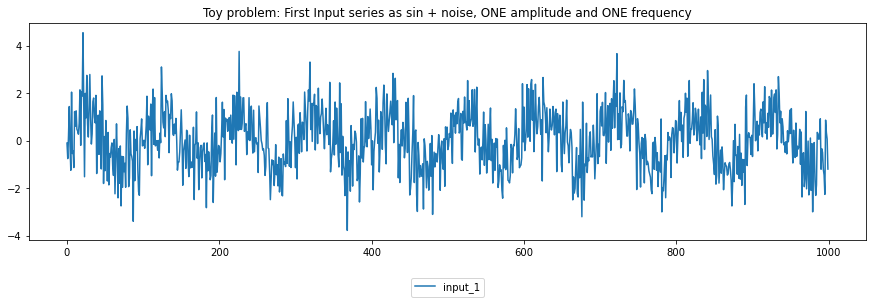

In [21]:
# Plot 1st input series
plt.figure(figsize=(15, 4))
plt.plot(range(len(input_1)), input_1, label='input_1')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.title('Toy problem: First Input series as sin + noise, ONE amplitude and ONE frequency')
plt.show()

### Single run for ESN on input_1

In [ ]:
### Train base ESN on input_1:

# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_1, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# Train base ESN.
# Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                              n_res=n_res, 
                              sparsity=sparsity, 
                              spectral_rad=spectral_rad, 
                              w_in_lim=w_in_lim, 
                              activation=activation, 
                              verbose=verbose)

# Get prediction on validation data and evaluation metrics
val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                              activation=activation,
                                              abs_values_YN=abs_values_YN,
                                              scaled_YN=scaled_YN, 
                                              train_min=train_min, 
                                              train_max=train_max, 
                                              verbose=verbose)

In [ ]:
# Fidelity check: Plot true vs. predicted absolute values
plt.figure(figsize=(16,8))
plt.plot(range(len(val_target)),val_target,'b',label="true data", alpha=0.3)
plt.plot(range(len(val_pred)),val_pred,'k',  alpha=0.8, label='pred ESN')
plt.legend()
plt.show()

### Multirun ESN on modified input_1 with varying noise level

In [ ]:
# Set number of runs per noise level
n_runs = 20

# Set noise levels
noise_grid = np.linspace(0,1,11)
print("noise_grid: ", noise_grid)

# Get verbose function outputs:
verbose = False

# Set input and target parameters:
input_length = 10
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with unscaled absolute values:
abs_to_rel_YN = False
binary_YN = False
scaled_YN = False
abs_values_YN = True

# Set reservoir parameters:
n_res=100
sparsity=0.2
spectral_rad=1.2
w_in_lim=1.0
activation='sigmoid'

# Initialize arrays for storing accuracy and mae for each run for each parameter selection.
grid_accuracy = np.zeros((len(noise_grid), n_runs))
grid_mae = np.zeros((len(noise_grid), n_runs))

# Note runtime: Start
start = time.time()

# Loop over noise levels in noise_grid:
for i in range(len(noise_grid)):
    
    # Get current n_res
    noise = noise_grid[i]
    
    # Create input according to current noise level: 

    # Specify number of steps per regime.
    n_ = 1000

    # Specify input for sin function with linspace(start, stop, numsteps)
    t = np.linspace(0, 20*np.pi, n_) 
    
    # Set the one amplitude a1, and one base frequency f1
    a1 = 1
    f1 = 1

    # Set noise standard deviation parameter n1
    n1 = noise

    # Add noise with np.random.normal(mean, std, numsteps).
    input = a1 * np.sin(f1 * t) + np.random.normal(0, n1, n_)

    # Loop over number of runs:
    for run in range(n_runs):

        # print status:
        print("noise level : ", i+1, " of ", len(noise_grid), ", run: ", run+1, " of ", n_runs)

        # Create inputs and targets from absolute data
        train_input, val_input, train_target, val_target, train_min, train_max = split_data(input, 
                                                                                            input_length = input_length, 
                                                                                            target_length = target_length, 
                                                                                            time_lag=time_lag,
                                                                                            train_val_split=train_val_split, 
                                                                                            abs_to_rel_YN=abs_to_rel_YN,
                                                                                            binary_YN=binary_YN, 
                                                                                            scaled_YN=scaled_YN,
                                                                                            verbose=verbose)

        # Train base ESN.
        # Note: Third dimension in train_input shape is for time_lag. Have only one slice here.
        W_in, W_res, W_out = trainESN(train_input[:,:,0], train_target, 
                                      n_res=n_res, 
                                      sparsity=sparsity, 
                                      spectral_rad=spectral_rad, 
                                      w_in_lim=w_in_lim, 
                                      activation=activation, 
                                      verbose=verbose)

        # Get prediction on validation data and evaluation metrics
        val_target, val_pred, accuracy, mae = predESN(W_in, W_res, W_out, val_input[:,:,0], val_target, 
                                                      activation=activation,
                                                      abs_values_YN=abs_values_YN,
                                                      scaled_YN=scaled_YN, 
                                                      train_min=train_min, 
                                                      train_max=train_max, 
                                                      verbose=verbose)

        # Store accuracy and mae for current run for current parameter selection:
        grid_accuracy[i,run] = accuracy
        grid_mae[i,run] = mae

# Get runtime:
duration = time.time() - start
print("Total runtime: ", duration)

In [ ]:
# Get mean accuracy and mae for grid over all runs:
mean_grid_accuracy = np.mean(grid_accuracy, axis=-1)
mean_grid_mae = np.mean(grid_mae, axis=-1)

In [ ]:
grid_accuracy[-1]

In [ ]:
# Saved grid search result in hard-coded manner:
mean_grid_accuracy = np.array([1.     , 0.4698 , 0.4452 , 0.4921 , 0.49135, 0.48505, 0.51925,
       0.50255, 0.5441 , 0.50075, 0.53435])
mean_grid_mae = np.array([2.05000e-04, 9.56650e-02, 1.94580e-01, 2.91075e-01, 3.98180e-01,
       4.67415e-01, 5.97795e-01, 6.09870e-01, 7.05285e-01, 8.05940e-01,
       8.67050e-01])

In [ ]:
# Plot mean accuracy for varying noise levels
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.plot(noise_grid, mean_grid_accuracy, color="k", label="mean accuracy")
axes.plot(noise_grid, mean_grid_mae, color="r", label="mean mae")
axes.set_xlabel("noise")
axes.set_ylabel("accuracy and mae")
axes.set_title("ESN on input_1: Mean accuracy depending on noise level")
axes.legend()
plt.show()

### Single run for CNN/LSTM on input_1

raw data shape:  (999,)
train_input shape:  (786, 16, 1)
val_input shape:  (197, 16, 1)
train_target shape:  (786,)
val_target shape:  (197,)
train_min:  -219.2063617870609
train_max:  959.5344498899719


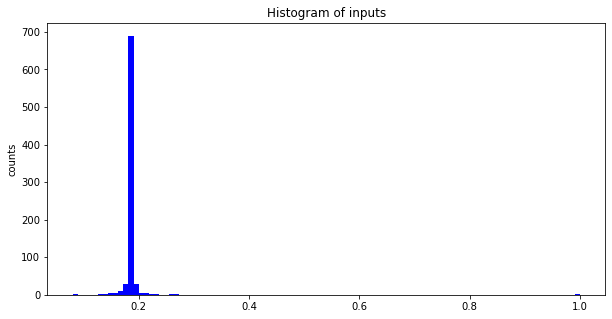

In [30]:
# Get verbose function outputs:
verbose = True

# Set input and target parameters:
input_length = 16
target_length = 1
time_lag = 0
train_val_split = 0.8

# Work with scaled rel. change values:
abs_to_rel_YN = True
binary_YN = False
scaled_YN = True

# Create inputs and targets from absolute data
train_input, val_input, train_target, val_target, train_min, train_max = split_data(input_1, 
                                                                                    input_length = input_length, 
                                                                                    target_length = target_length, 
                                                                                    time_lag=time_lag,
                                                                                    train_val_split=train_val_split, 
                                                                                    abs_to_rel_YN=abs_to_rel_YN,
                                                                                    binary_YN=binary_YN, 
                                                                                    scaled_YN=scaled_YN,
                                                                                    verbose=verbose)

# check distribution of input values
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input[:,0], nBins, color="blue")
axes.set_ylabel("counts")
axes.set_title("Histogram of inputs")
plt.show()

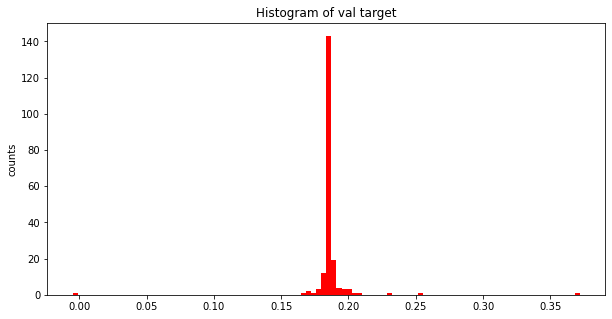

In [31]:
# check distribution of val target as scaled rel. change values
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(val_target, nBins, color="red")
axes.set_ylabel("counts")
axes.set_title("Histogram of val target")
plt.show()

In [32]:
### Preparing CNN/LSTM model setup

# number of input features
num_channels = 1

# input dimensions
input_shape = (np.shape(train_input)[1], num_channels)    
num_inputs = train_input.shape[1] * num_channels
num_outputs = 1 

# further parameters: weight/bias initialization
weight_init = tfi.glorot_uniform() # tfi.RandomUniform(minval=-0.05, maxval=0.05, seed=None)  tfi.RandomNormal()
bias_init = tfi.Zeros()

# further parameters: regularization
kernel_reg_CNN=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_CNN=tfr.l2(0) # l2(1e-4) 
kernel_reg_LSTM=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_LSTM=tfr.l2(0) # l2(1e-4) 
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0) # (l1=1e-5, l2=1e-4)
bias_reg_Dense=tfr.l2(0) # l2(1e-4) 

# batch size
batch_size = 20  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 10, 10)            80        
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 10)            40        
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 10, 10)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 20)             820       
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 20)             80        
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 20)             0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7, 20)            

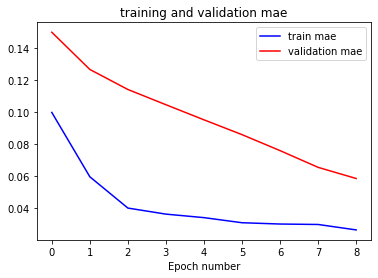

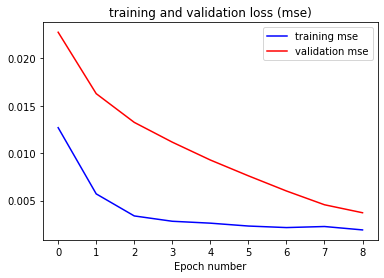

In [33]:
#########################################
# define model: hybrid CNN-LSTM         #
#########################################

model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_CNN, bias_regularizer=bias_reg_CNN))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(LSTM(10, kernel_regularizer=kernel_reg_LSTM, bias_regularizer=bias_reg_LSTM))
#model.add(Dropout(0.5))
model.add(Dense(units=num_outputs, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init, kernel_regularizer=kernel_reg_Dense, bias_regularizer=bias_reg_Dense))

# compile model (with constant lr)
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=['mae'])
model.summary()

# train model
history = model.fit(train_input, train_target, epochs=9, batch_size=batch_size, shuffle=True, verbose=1, validation_data=(val_input, val_target))

# plot train and validation mae
plt.plot(history.history['mae'], color = 'blue', label = 'train mae')
plt.plot(history.history['val_mae'], color = 'red', label = 'validation mae')
plt.xlabel('Epoch number')
plt.title('training and validation mae')
plt.legend()
plt.show()
    
# plot train and val_loss
plt.plot(history.history['loss'], color = 'blue', label = 'training mse')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation mse')
plt.xlabel('Epoch number')
plt.title('training and validation loss (mse)')
plt.legend()
plt.show()  

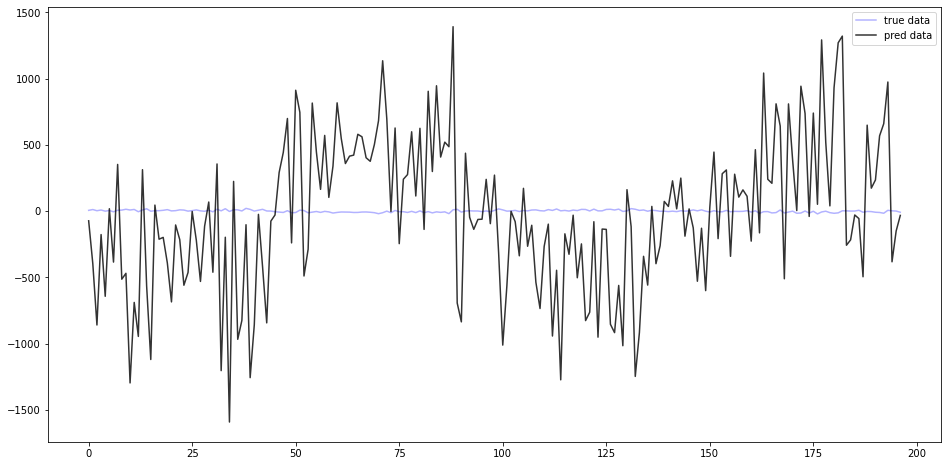

val_input shape:  (197, 16, 1)
val_target shape:  (197,)
val_pred shape:  (197, 1)
val_target_abs shape:  (197,)
val_pred_abs shape:  (197,)
up movements percentage in val_target:  0.355
ESN pred. accuracy:  0.645
ESN mean abs. error (rel. change values):  68.8682
ESN mean abs. error (absolute values):  451.4074


In [34]:
# Get prediction on validation data and evaluation metrics
val_target_abs, val_pred_abs, accuracy, mae_rel_chg, mae_abs = predCNNLSTM(val_input, val_target,
                                                                              model,
                                                                              target_length=target_length,
                                                                              scaled_YN=scaled_YN, 
                                                                              train_min=train_min, 
                                                                              train_max=train_max, 
                                                                              abs_base=1.0,
                                                                              verbose=verbose)